In [38]:
import pandas as pd
import numpy as np
import regex as re
import seaborn as sns
from datetime import datetime
from scipy.interpolate import LSQUnivariateSpline
import numpy as np
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from scipy.stats import norm
import scipy.stats as stats


# read excel file
df = pd.read_excel('C1Data.xlsx', sheet_name=None)

# name the sheets
bonds = df['Bonds']
yield_curve = df['YieldCurve']

# change columns to datetime
bonds['OFFERING_DATE'] = pd.to_datetime(bonds['OFFERING_DATE'])
bonds['MATURITY'] = pd.to_datetime(bonds['MATURITY'])
bonds['TRD_EXCTN_DT'] = pd.to_datetime(bonds['TRD_EXCTN_DT'])

#find the ones where the trade date is after the maturity date and remove them
bonds = bonds[bonds['TRD_EXCTN_DT'] < bonds['MATURITY']]

# get rid of the row where the principal amount is 1
bonds = bonds[~(bonds['PRINCIPAL_AMT'] == 1)]

# drop na in the yield_curve data
yield_curve.dropna(inplace=True)

# change the column names
yield_curve.columns = ['Date', '2024_data', '2025_data']

# make regex that only gets numbers and apply to the Date column
yield_curve['Date'] = yield_curve['Date'].apply(lambda x: re.findall(r'\d+', x)[0])

# change date column to numeric
yield_curve['Date'] = pd.to_numeric(yield_curve['Date'])/100

# change the data columns to numeric
yield_curve['2024_data'] = pd.to_numeric(yield_curve['2024_data'])
yield_curve['2025_data'] = pd.to_numeric(yield_curve['2025_data'])



Text(0, 0.5, 'Yield')

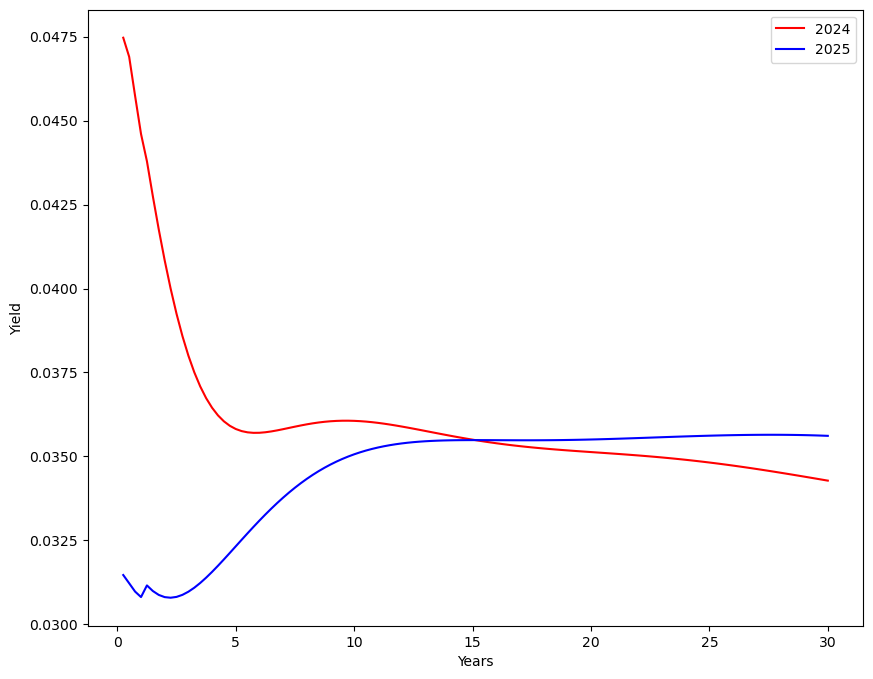

In [39]:
# plot the yield curve
plt.figure(figsize=(10, 8))

plt.plot(yield_curve['Date'], yield_curve['2024_data'], label='2024', color='red')
plt.plot(yield_curve['Date'], yield_curve['2025_data'], label='2025', color='blue')
plt.legend()

# axis labels
plt.xlabel('Years')
plt.ylabel('Yield')

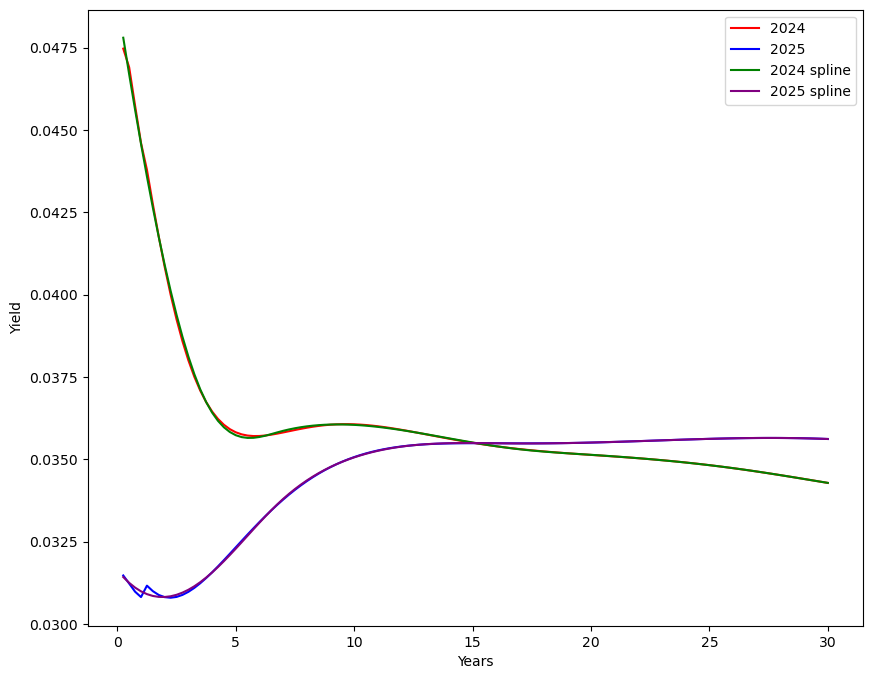

In [40]:
######### make model for splines to inteporlate the yield curve #########

# Define the positions of the knots (excluding the endpoints)
knots = np.linspace(yield_curve['Date'].min(), yield_curve['Date'].max(), 10)[1:-1]

# make the spline with specified knots
spline_2024 = LSQUnivariateSpline(yield_curve['Date'], yield_curve['2024_data'], t=knots, k=3)
spline_2025 = LSQUnivariateSpline(yield_curve['Date'], yield_curve['2025_data'], t=knots, k=3)

# make the plot
plt.figure(figsize=(10, 8))

plt.plot(yield_curve['Date'], yield_curve['2024_data'], label='2024', color='red')
plt.plot(yield_curve['Date'], yield_curve['2025_data'], label='2025', color='blue')

plt.plot(yield_curve['Date'], spline_2024(yield_curve['Date']), label='2024 spline', color='green')
plt.plot(yield_curve['Date'], spline_2025(yield_curve['Date']), label='2025 spline', color='purple')

plt.legend()

# axis labels
plt.xlabel('Years')
plt.ylabel('Yield')
plt.show()

In [41]:
# given a date and a list of cash flow dates, find the number of years to the next cash flow date
def years_to_next_date(date, cash_flow_dates):

    days_to_next = [(cash_flow_date - date).days for cash_flow_date in cash_flow_dates if cash_flow_date > date]

    return min(days_to_next)/365

# fuction that given a start date, end date and frequency returns a list of dates that are the cash flow dates
def cashflow_dates(start_date, end_date, frequency):
    dates = []
    current_date = start_date

    while current_date > end_date:
        dates.append(current_date.date())
        current_date -= relativedelta(months=12/frequency)

    return dates


# given a bond with its maturity date, coupon frequency, issue date and interest rate and principal amount make a df of all the cash flows and the number of years away each one is
def cashflows_and_years(offering_date, maturity_date, frequency, today, principal, interest_rate):

    # generate cashflow dates
    cash_flow_dates = cashflow_dates(maturity_date, offering_date, frequency)
    
    # remove all cash flows that are before today
    cash_flow_dates = [date for date in cash_flow_dates if date > today]

    # find the years to the next coupon date
    years_to_next_coupon = years_to_next_date(today, cash_flow_dates)

    # get the years to maturity of each cash flow, the first one is the number of days from today until the next coupon then each coupon is 12/frequency more
    years = np.arange(len(cash_flow_dates) - 1, -1, -1) * 1/frequency + years_to_next_coupon

    # combine cash flow dates and years into a df
    cash_flows = pd.DataFrame({'Date': cash_flow_dates, 'Years': years})

    # add cashflow amounts
    cash_flows['Amount'] = principal * interest_rate/frequency

    # add the principal to the first cashflow
    cash_flows.loc[cash_flows.index[0], 'Amount'] += principal

    return cash_flows

# a function that given the cashflows and the spline model of the yields discounts each one to the present value
def present_value(cash_flows, spline, spread=0):

    cash_flows['Discounted'] = cash_flows['Amount']/((1 + spline(cash_flows['Years']) + spread)**cash_flows['Years'])

    return sum(cash_flows['Discounted'])

# make a function that combines everything
def bond_value(offering_date, maturity_date, frequency, today, principal, interest_rate, spline, spread):

    cashflows = cashflows_and_years(offering_date, maturity_date, frequency, today, principal, interest_rate)
    
    return present_value(cashflows, spline, spread)

# set day to 2024-05
date_2024 = datetime(2024, 5, 31).date()

# apply the bond_value function to the bonds df
bonds['2024_value'] = bonds.apply(lambda x: bond_value(x['OFFERING_DATE'], 
                                                  x['MATURITY'], 
                                                  x['INTEREST_FREQUENCY'], 
                                                  date_2024, 
                                                  x['PRINCIPAL_AMT'], 
                                                  x['COUPON']/100, 
                                                  spline_2024, 
                                                  x['TREASURY_SPREAD']/100/100), axis=1)

# the total price of all the bonds in the canadian market
bonds['2024_value'].sum()

9739715.52458329

In [42]:
# the total price of all the bonds in the USA market
bonds['raw_reported_price'] = bonds['RPTD_LAST_PR'] * bonds['PRINCIPAL_AMT'] /100
bonds['raw_reported_price'].sum()


9417960.74751

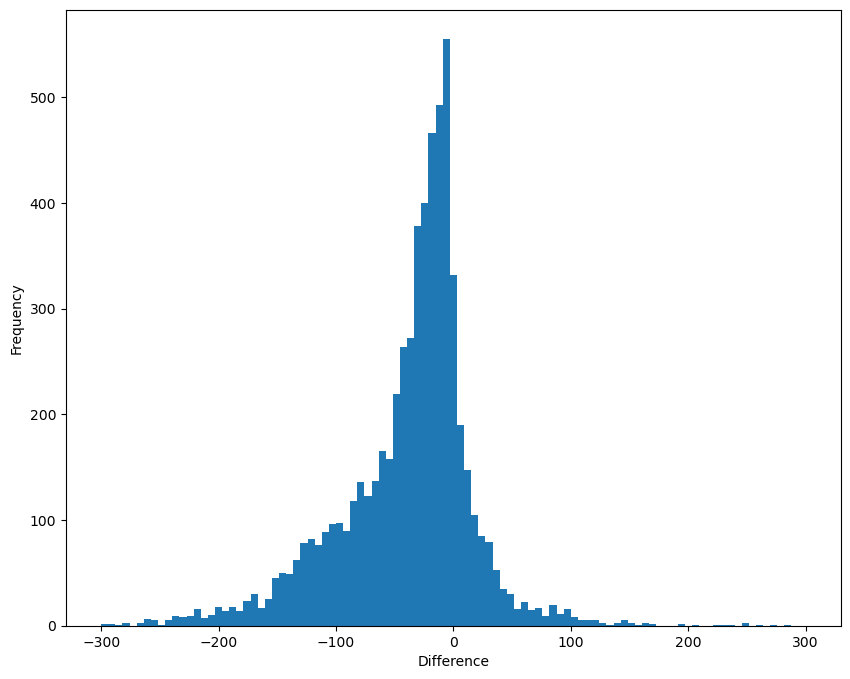

In [43]:
# take the difference between the usa prices and the canadian prices
bonds['difference'] = bonds['raw_reported_price'] - bonds['2024_value']

# histogram the differences only for a certain range
plt.figure(figsize=(10, 8)) 

plt.hist(bonds['difference'], bins=np.linspace(-300, 300, 100))

plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()

In [44]:
# 2025 bond prices

# set day to jan 13, 2025
date_2025 = datetime(2025, 1, 13).date()

# remove the bonds that have already matured
bonds_2025 = bonds[bonds['MATURITY'] > datetime(2025,1,13)].copy()

# apply the bond_value function to the bonds df
bonds_2025['2025_value'] = bonds_2025.apply(lambda x: bond_value(x['OFFERING_DATE'], 
                                                  x['MATURITY'], 
                                                  x['INTEREST_FREQUENCY'], 
                                                  date_2025, 
                                                  x['PRINCIPAL_AMT'], 
                                                  x['COUPON']/100, 
                                                  spline_2025, 
                                                  x['TREASURY_SPREAD']/100/100), axis=1)

# sum of all teh bond values
bonds_2025['2025_value'].sum()

9506016.551182808

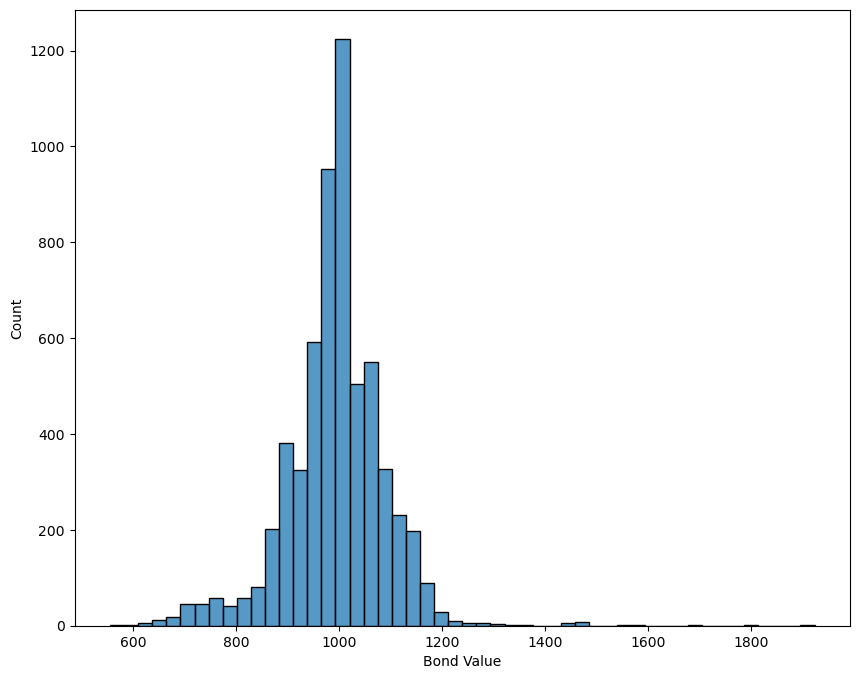

In [45]:
# make a distribution of the bond values for the bonds less than 100 000
plt.figure(figsize=(10, 8))

sns.histplot(bonds_2025[bonds_2025['2025_value'] < 2000]['2025_value'], bins=50)

plt.xlabel('Bond Value')

plt.show()

In [46]:
bonds_2025.head()

,ISSUE_ID,TRD_EXCTN_DT,RPTD_LAST_PR,MATURITY,TREASURY_SPREAD,OFFERING_DATE,PRINCIPAL_AMT,INTEREST_FREQUENCY,COUPON,RATING,SECURITY_LEVEL,2024_value,raw_reported_price,difference,2025_value
0,2560,2024-05-31,114.375,2031-09-15,80.0,1991-09-10,1000,2,8.750,BBB,SEN,1288.882531,1143.75,-145.132531,1299.344489
1,2562,2024-05-31,113.800,2031-11-15,85.0,1991-11-08,1000,2,8.625,BBB,SEN,1268.053609,1138.00,-130.053609,1278.997241
3,2564,2024-05-31,114.080,2043-04-15,100.0,1993-04-06,1000,2,7.875,BBB,SEN,1435.084790,1140.80,-294.284790,1443.434116
4,2566,2024-05-31,100.915,2025-06-15,69.0,1993-06-29,1000,2,7.250,BBB,SEN,1055.062910,1009.15,-45.912910,1020.093768
5,3857,2024-05-31,107.528,2029-10-15,8.0,1989-10-17,1000,2,8.000,BBB,SEN,1220.277010,1075.28,-144.997010,1227.372563


Simulation 0/10000
Simulation 1000/10000
Simulation 2000/10000
Simulation 3000/10000
Simulation 4000/10000
Simulation 5000/10000
Simulation 6000/10000
Simulation 7000/10000
Simulation 8000/10000
Simulation 9000/10000
        Simulation  Capital Requirement  Expected Loss
count  10000.00000         10000.000000   10000.000000
mean    4999.50000        547111.816582    8238.584699
std     2886.89568         15744.839360     870.008059
min        0.00000        510709.684444    6707.674754
25%     2499.75000        535715.283338    7674.723080
50%     4999.50000        545591.460207    8067.647621
75%     7499.25000        556611.915632    8578.899903
max     9999.00000        621967.851909   17913.963395


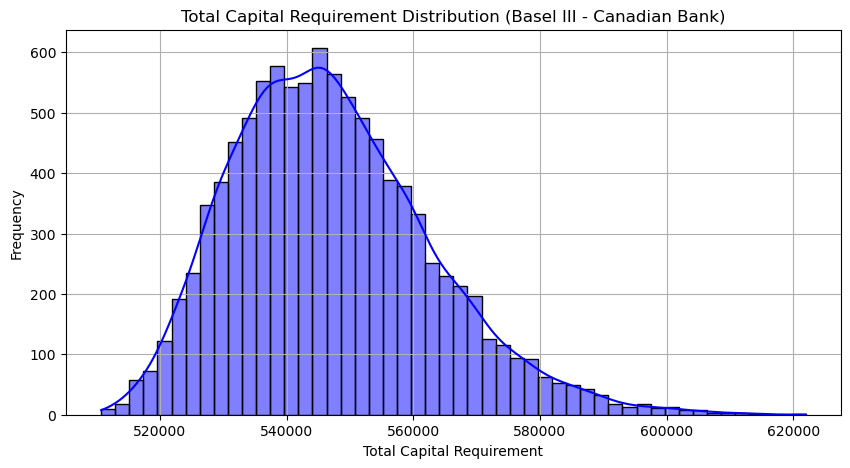

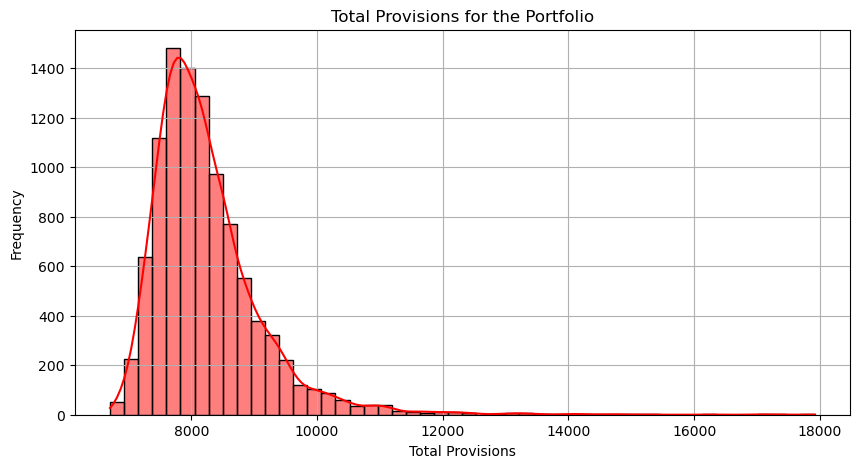


=== Descriptive Statistics for Capital Requirements ===
count     10000.000000
mean     547111.816582
std       15744.839360
min      510709.684444
5%       524348.702066
50%      545591.460207
95%      575634.033381
99%      590603.947502
max      621967.851909
dtype: float64

=== Descriptive Statistics for Total Provisions (Expected Losses) ===
count    10000.000000
mean      8238.584699
std        870.008059
min       6707.674754
5%        7249.901963
50%       8067.647621
95%       9760.335608
99%      11230.300939
max      17913.963395
dtype: float64


In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, lognorm
from scipy.interpolate import interp1d
from datetime import datetime

# Load Excel file
xls = pd.ExcelFile("C1Data.xlsx")

# Load required sheets
bonds_df = pd.read_excel(xls, sheet_name="Bonds", parse_dates=["TRD_EXCTN_DT", "MATURITY", "OFFERING_DATE"])
yield_curve_df = pd.read_excel(xls, sheet_name="YieldCurve")
rating_df = pd.read_excel(xls, sheet_name="RatingDFRate2024")

# Clean yield curve data
yield_curve_df.dropna(inplace=True)
yield_curve_df.columns = ["Date"] + [str(col).split(" ")[0] for col in yield_curve_df.columns[1:]]
yield_curve_df["Date"] = yield_curve_df["Date"].astype(str).str.extract(r'(\d+)').astype(float) / 100
yield_curve_df.iloc[:, 1:] = yield_curve_df.iloc[:, 1:].apply(pd.to_numeric)

# Interpolation setup
interp_func_2024 = interp1d(yield_curve_df["Date"], yield_curve_df["2024-05-31"], kind='cubic', fill_value="extrapolate")
interp_func_2025 = interp1d(yield_curve_df["Date"], yield_curve_df["2025-01-13"], kind='cubic', fill_value="extrapolate")
date_range = np.linspace(yield_curve_df["Date"].min(), yield_curve_df["Date"].max(), 100)

# Extract PD data from rating sheet
rating_df.set_index(rating_df.iloc[:, 0], inplace=True)
rating_df = rating_df.iloc[:, 1:]
pd_mean_series = rating_df.loc["Weighted long-term average"] / 100
pd_std_series = rating_df.loc["Standard deviation"] / 100

# Apply PD values to bonds
bonds_2025 = bonds_df.copy()
bonds_2025["PD_mean"] = bonds_2025["RATING"].map(pd_mean_series)
bonds_2025["PD_std"] = bonds_2025["RATING"].map(pd_std_series)

# LGD Calculation
bonds_2025['LGD'] = np.where(bonds_2025['SECURITY_LEVEL'].isin(['SEN', 'SS']), 0.45, 0.75)

# Maturity years calculation
date_2024 = pd.to_datetime(datetime(2024, 5, 31))
bonds_2025['MATURITY'] = pd.to_datetime(bonds_2025['MATURITY'], errors='coerce')
bonds_2025['Maturity_years'] = (bonds_2025['MATURITY'] - date_2024).dt.days / 365

# Monte Carlo Simulation Setup
num_simulations = 10000
pd_mean = bonds_2025['PD_mean'].fillna(0).values
pd_std = bonds_2025['PD_std'].fillna(0).values
lgd = bonds_2025['LGD'].values
ead = bonds_2025['PRINCIPAL_AMT'].values
maturity_years = bonds_2025['Maturity_years'].values

# Fix zero PD values
pd_mean_fixed = np.where(pd_mean > 0, pd_mean, 1e-6)
pd_std_fixed = np.where(pd_std > 0, pd_std, 1e-6)

# Monte Carlo Simulation
capitalreq_fixed = np.zeros(num_simulations)
expected_losses = np.zeros(num_simulations)
for i in range(num_simulations):
    if i % 1000 == 0:
        print(f"Simulation {i}/{num_simulations}")
    z_values = np.random.normal(0, 1, len(bonds_2025))
    sigma = np.sqrt(np.log(1 + (pd_std_fixed ** 2 / pd_mean_fixed ** 2)))
    mu = np.log(pd_mean_fixed) - (sigma ** 2 / 2)
    cumulative_probs = norm.cdf(z_values)
    simulated_pds = lognorm.ppf(cumulative_probs, s=sigma, scale=np.exp(mu))
    simulated_pds = np.clip(simulated_pds, 0.0005, 1)
    PD_clipped = np.clip(simulated_pds, 1e-9, 1 - 1e-9)
    R = 0.12 * (1 - np.exp(-50 * PD_clipped)) / (1 - np.exp(-50)) + \
        0.24 * (1 - (1 - np.exp(-50 * PD_clipped)) / (1 - np.exp(-50)))
    b = (0.11852 - 0.05478 * np.log(PD_clipped)) ** 2
    adjustment = (1 + (maturity_years - 2.5) * b) / (1 - 1.5 * b)
    K = (lgd * norm.cdf((norm.ppf(PD_clipped) + np.sqrt(R) * norm.ppf(0.999)) / np.sqrt(1 - R)) - PD_clipped * lgd)
    capitalreq_fixed[i] = np.sum(K * adjustment * ead)
    
    # Calculate Expected Loss (EL) for each simulation
    expected_losses[i] = np.sum(simulated_pds * lgd * ead)

# Results
capitalreq_summary_fixed = pd.DataFrame({
    "Simulation": np.arange(num_simulations),
    "Capital Requirement": capitalreq_fixed,
    "Expected Loss": expected_losses
})

# Display summary statistics
print(capitalreq_summary_fixed.describe())

# Save results to CSV for further analysis
capitalreq_summary_fixed.to_csv("capital_requirement_summary.csv", index=False)

# -------------------------------------------
# Generate Histograms for Required Outputs
# -------------------------------------------

# Histogram for Total Capital Requirement Distribution (Basel III)
plt.figure(figsize=(10, 5))
sns.histplot(capitalreq_fixed, bins=50, kde=True, color='blue')
plt.xlabel("Total Capital Requirement")
plt.ylabel("Frequency")
plt.title("Total Capital Requirement Distribution (Basel III - Canadian Bank)")
plt.grid(True)
plt.show()

# Histogram for Total Provisions for the Portfolio
plt.figure(figsize=(10, 5))
sns.histplot(expected_losses, bins=50, kde=True, color='red')
plt.xlabel("Total Provisions")
plt.ylabel("Frequency")
plt.title("Total Provisions for the Portfolio")
plt.grid(True)
plt.show()

# -------------------------------------------
# Descriptive Statistics for Capital Requirements and Expected Losses
# -------------------------------------------
capitalreq_stats = pd.Series(capitalreq_fixed).describe(percentiles=[0.05, 0.95, 0.99])
expected_loss_stats = pd.Series(expected_losses).describe(percentiles=[0.05, 0.95, 0.99])

# Print summary statistics
print("\n=== Descriptive Statistics for Capital Requirements ===")
print(capitalreq_stats)

print("\n=== Descriptive Statistics for Total Provisions (Expected Losses) ===")
print(expected_loss_stats)
